In [1]:
#Import packages
import pandas as pd
import numpy as np
import glob

from functions import plotting_raw_data, remove_outliers, error_plot, plot_cpt_data, plot_cpt_data_ML_prediction, plot_cpt_data_NW_site

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_param_importances, plot_optimization_history

c:\Users\haris\Documents\GitHub\ISGSR25_DataDrivenSiteCharacterization\DataDriven\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
######################## Define the text size of each plot globally ###########
SMALL_SIZE = 10
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
cm = 1/2.54  # centimeters in inches

In [3]:
data_ML = pd.read_csv('..\data\database_preprocessed.csv')
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
0,0.79,0.153000,5.333333,3.485839,14.888889,16.410000,1.554000,4.123596,NaN,Ballina_Inclo 2
1,1.76,0.158000,8.111111,5.133615,45.777778,16.240000,NaN,NaN,9.4,Ballina_Inclo 2
2,1.86,0.159222,7.444444,4.675506,56.444444,16.420000,2.843000,3.264286,NaN,Ballina_Inclo 2
3,1.96,0.149333,7.111111,4.761905,82.222222,16.150000,NaN,NaN,12.3,Ballina_Inclo 2
4,2.27,0.176000,7.000000,3.977273,101.444444,15.800000,1.303000,2.182143,NaN,Ballina_Inclo 2
...,...,...,...,...,...,...,...,...,...,...
378,12.90,0.690000,9.500000,1.376812,372.500000,17.576633,3.342717,1.013250,NaN,PITS_Rhesi_KB02
379,12.90,0.690000,9.500000,1.376812,372.500000,17.924784,NaN,NaN,NaN,PITS_Rhesi_KB02
380,12.90,0.690000,9.500000,1.376812,372.500000,17.924784,4.504654,1.208106,NaN,PITS_Rhesi_KB02
381,4.80,0.480000,8.800000,1.833333,310.500000,17.924784,0.902065,NaN,NaN,PITS_Seekirchen_BS01


In [4]:
prefix = r'..\graphics\\'
investigated_column =  ['gamma (kN/m3)', 'su (kPa)', 'M (MN/m2)', 'OCR (-)']
investigated_column_plot =  ['$\gamma$ (kN/m$^3$)', '$s_u$ (kPa)', 'M (MN/m$^2$)', 'OCR (-)']
save_paths = [prefix + '1_gamma_prediction.png', prefix + '2_su_prediction.png', prefix + '3_M_prediction.png']
axis_limit = [(13, 22), (0, 200), (0, 20), (0,20)]

j = 2
investigated_column_plot = investigated_column_plot[j]
investigated_column = investigated_column[j]
save_path = save_paths[j]

data_ML = data_ML.dropna(subset=[investigated_column])
print(f"{investigated_column} is selected to predict, {investigated_column_plot} is plotted, {save_path} is saved, {axis_limit[j]} is the axis limit, {len(data_ML)} is the length of the data")

columns_x = ['Depth (m)','qc (MPa)', 'fs (kPa)','Rf (%)'] #for Machine learning features
plot_columns_x_label = ['Depth (m)','$q_c$ (MPa)', '$f_s$ (kPa)','$R_f$ (%)'] #for plotting purpose

X = data_ML.loc[:,columns_x]
y = data_ML[investigated_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

M (MN/m2) is selected to predict, M (MN/m$^2$) is plotted, ..\graphics\\3_M_prediction.png is saved, (0, 20) is the axis limit, 114 is the length of the data


In [5]:
data_ML

,Depth (m),qc (MPa),fs (kPa),Rf (%),u2 (kPa),gamma (kN/m3),M (MN/m2),OCR (-),su (kPa),sampling_name(-)
0,0.790,0.153000,5.333333,3.485839,14.888889,16.410000,1.554000,4.123596,NaN,Ballina_Inclo 2
2,1.860,0.159222,7.444444,4.675506,56.444444,16.420000,2.843000,3.264286,NaN,Ballina_Inclo 2
4,2.270,0.176000,7.000000,3.977273,101.444444,15.800000,1.303000,2.182143,NaN,Ballina_Inclo 2
10,3.140,0.186556,7.111111,3.811793,126.000000,14.830000,1.140000,1.772021,NaN,Ballina_Inclo 2
12,3.650,0.223444,9.222222,4.127300,92.888889,NaN,1.657000,1.860129,NaN,Ballina_Inclo 2
...,...,...,...,...,...,...,...,...,...,...
373,10.075,0.953000,20.512000,2.152361,205.587000,19.740000,8.700000,2.803738,NaN,NGTS_Silt_HALB06
377,13.065,0.946000,20.876000,2.206765,297.722000,19.920000,11.400000,1.619718,NaN,NGTS_Silt_HALB06
378,12.900,0.690000,9.500000,1.376812,372.500000,17.576633,3.342717,1.013250,NaN,PITS_Rhesi_KB02
380,12.900,0.690000,9.500000,1.376812,372.500000,17.924784,4.504654,1.208106,NaN,PITS_Rhesi_KB02


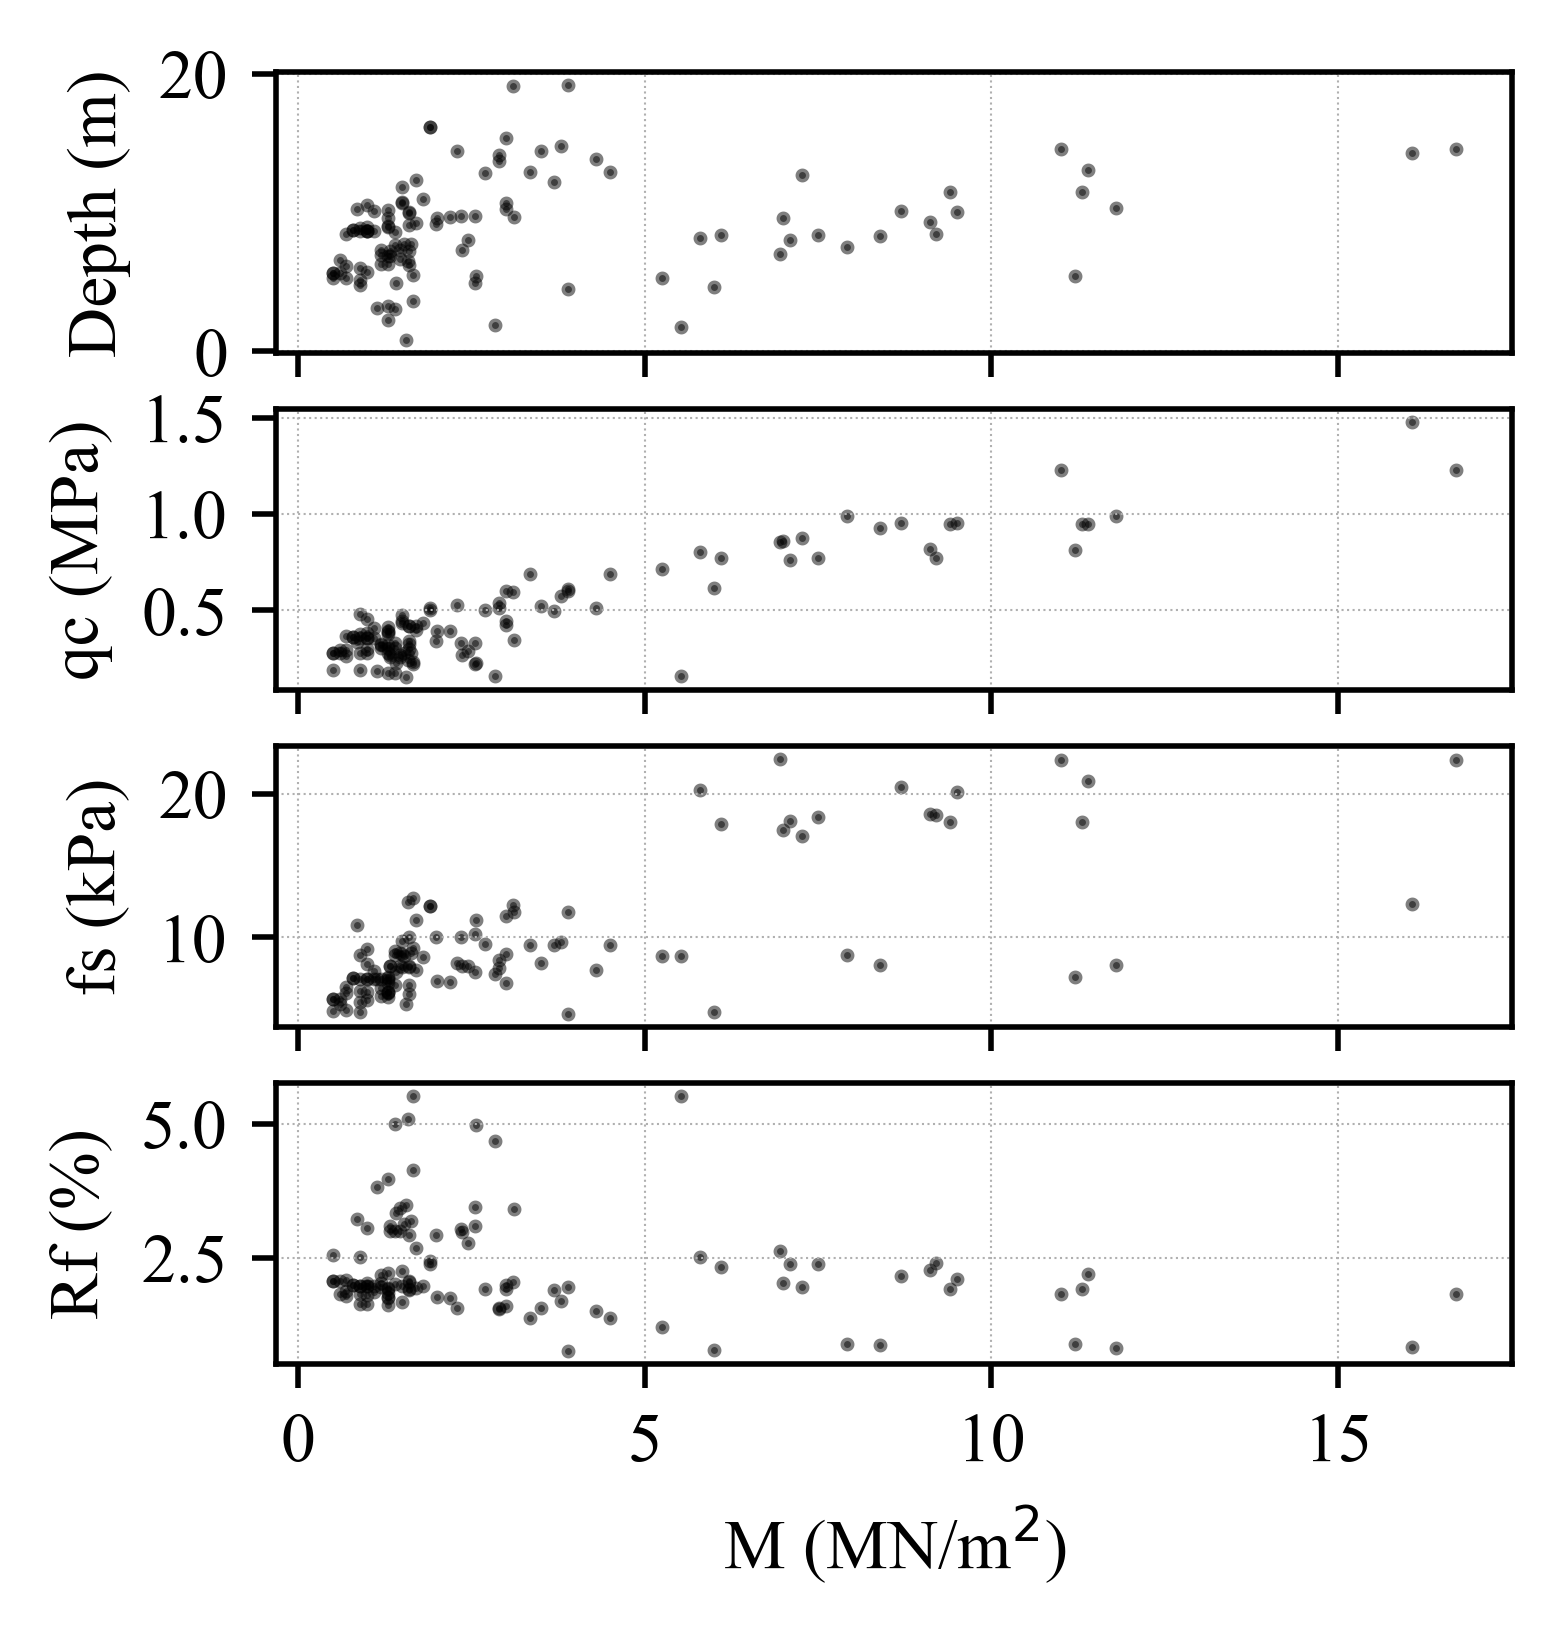

In [17]:
# Plotting training data 
s = 1  # Adjust the marker size as needed
color = 'k'  # Adjust the marker color as needed
alpha = 0.5

columns_x.append(investigated_column_plot)

#Plot scatter points: raw data points as
fig, axes = plt.subplots(4, 1, figsize=(7.75*cm, 8*cm), dpi=500, sharex=True)
plotting_raw_data(X,y, alpha, s, color, True, axes, columns_x, 'Raw data', False)

#plotting_raw_data(X,y, alpha, s, 'r', 'Removed outliers', False, axes, plot_columns_x_label)
# Adjust layout to prevent overlapping
plt.subplots_adjust(left=0.18, right=0.99, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
plt.savefig(f"{prefix}{j+1}_raw_data.png", dpi = 1000)

In [7]:
# # Plotting training data
# s = 1  # Adjust the marker size as needed
# color = 'k'  # Adjust the marker color as needed
# alpha = 0.5

# columns_x.append(investigated_column)

# # Plot scatter points: raw data points
# fig, axes = plt.subplots(4, 1, figsize=(20*cm, 20*cm), dpi=500, sharex=True)
# plotting_raw_data(X, y, alpha, s, color, True, axes, columns_x, 'Raw data', False)

# xlim, ylim = axis_limit[j][0], axis_limit[j][1]

# # Set ticks for each subplot
# for ax in axes:
#     ax.set_xticks(np.arange(xlim, ylim + 0.001, (ylim - xlim) / 4))

# # Set sampling_name as the index and create separate DataFrames for each unique sampling_name
# grouped_dfs = {name: group.set_index('sampling_name(-)') for name, group in data_ML.groupby('sampling_name(-)')}

# color_list = ['b', 'r', 'm', 'green', 'brown', 'orange', 'brown', 'pink', 'grey', 'cyan']
# k = 0
# m = 0 
# print(len(grouped_dfs.keys()))


# # Iterate over each DataFrame for unique sampling names
# for sampling_name in grouped_dfs.keys():
#     df = grouped_dfs[sampling_name]
#     with open(f"{prefix}{j+1}_sampling_name.txt", "a") as f:
#         f.write(f"Sampling name: {sampling_name}, Number of data points: {len(df)}\n")
#     X1 = df.loc[:, columns_x]
#     y1 = df[investigated_column]
#     plotting_raw_data(X1, y1, alpha, 5, color_list[k], False, axes, columns_x, sampling_name, False)
#     m += 1  
#     if m == 3:
#         k = 1
#     elif m == 24:
#         k = 2
#     elif m == 27:
#         k = 3
#     elif m == 32:
#         k = 4
#     elif m == 35:
#         k = 5
#     elif m == 42:
#         k = 6


# # Add legend to the top of the first subplot with high zorder
# legend = axes[-1].legend(loc='upper center', bbox_to_anchor=(0.8, 4.5))

# # Add text and adjust layout
# fig.text(0.02, 0.02, rf'{len(data_ML)} datapoints', ha='left', va='center', fontsize=10, color='black', alpha=0.5)
# plt.subplots_adjust(left=0.20, right=0.93, top=0.97, bottom=0.15, wspace=0.15, hspace=0.2)
# plt.savefig(f"{prefix}{j+1}_raw_data.png", dpi=1000)

In [8]:
RS = 44  # random state
N_JOBS = -1  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

# Optuna
N_TRIALS = 200

# XGBoost
EARLY_STOPPING_ROUNDS = 10

In [9]:
def objective(trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=-1,
              ):
    
    param = {
        "objective": "reg:squarederror",
        "tree_method":'hist',
        'n_estimators': trial.suggest_int('n_estimators', 50, 120),
        "verbosity": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.5, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 0.9,log=True),
        "n_jobs": n_jobs,
    }
    
    model = xgb.XGBRegressor(**param, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)

    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose=0,)
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    r2 = r2_score(y_true = y_train, y_pred = y_pred)
    
    return r2


sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler = sampler, direction='maximize')
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=RS,
        n_splits=N_SPLITS,
        n_repeats=N_REPEATS,
        n_jobs=N_JOBS,
    ),
    n_trials=N_TRIALS,
    n_jobs=N_JOBS,
)

[I 2024-10-31 09:24:12,675] A new study created in memory with name: no-name-9fce65c0-9d34-4859-8c99-638d2717c241
[I 2024-10-31 09:24:14,592] Trial 1 finished with value: 0.7303581792837245 and parameters: {'n_estimators': 52, 'learning_rate': 0.42169519760153545, 'max_depth': 5, 'subsample': 0.055624965500480954}. Best is trial 1 with value: 0.7303581792837245.
[I 2024-10-31 09:24:15,671] Trial 0 finished with value: 0.8056188529186201 and parameters: {'n_estimators': 102, 'learning_rate': 0.3547032897268067, 'max_depth': 6, 'subsample': 0.21578304981217805}. Best is trial 0 with value: 0.8056188529186201.
[I 2024-10-31 09:24:15,758] Trial 7 finished with value: 0.8078656179129987 and parameters: {'n_estimators': 80, 'learning_rate': 0.31050698651697795, 'max_depth': 8, 'subsample': 0.17048407795551243}. Best is trial 7 with value: 0.8078656179129987.
[I 2024-10-31 09:24:16,267] Trial 4 finished with value: 0.8476032165374447 and parameters: {'n_estimators': 98, 'learning_rate': 0.229

In [10]:
# Plot optimization history
plot_optimization_history(study)

In [11]:
# Plot parameter importances
plot_param_importances(study)

In [12]:
hp = study.best_params

for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["tree_method"] = "hist"
hp["seed"] = RS
hp["n_jobs"] = N_JOBS

        n_estimators : 110
       learning_rate : 0.12568896915364217
           max_depth : 10
           subsample : 0.5134582351422102
best objective value : 0.8699537941900298


In [13]:
model = xgb.XGBRegressor(**hp, eval_metric="rmse",early_stopping_rounds = EARLY_STOPPING_ROUNDS)
rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RS)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= N_REPEATS * N_SPLITS

In [14]:
score, mse = r2_score(y_true=y_test, y_pred=y_pred), mean_squared_error(y_true=y_test, y_pred=y_pred)

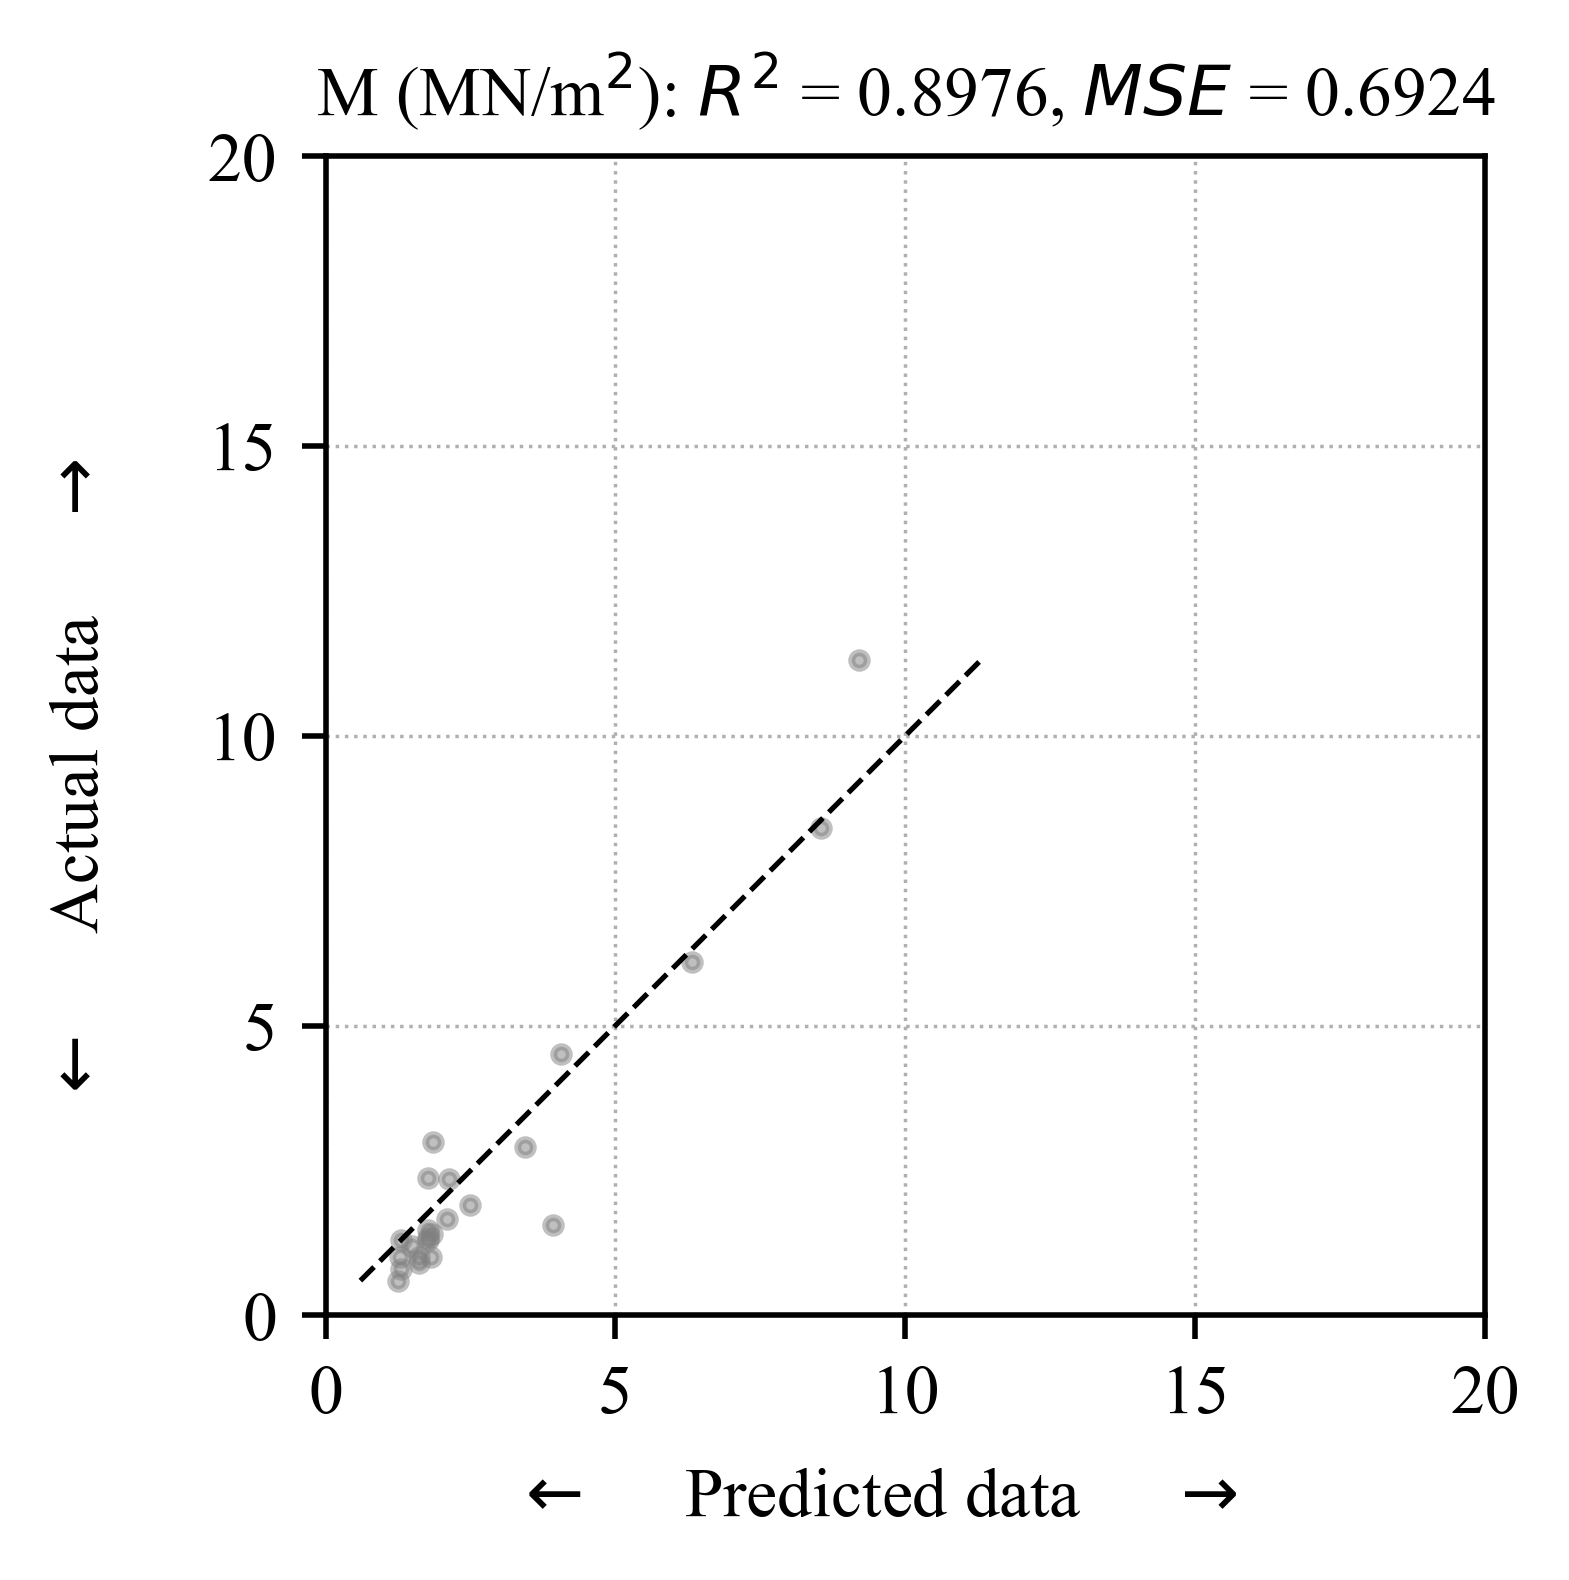

In [15]:
from sklearn.metrics import PredictionErrorDisplay

figsize= (15.5/2*cm, 15.5/2*cm)

y_true = y_test
y_pred = pd.DataFrame(y_pred)


# Define plot structure
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=500)

ped = PredictionErrorDisplay.from_predictions(y_true=y_true,
                                            y_pred=y_pred,
                                            kind="actual_vs_predicted",
                                            subsample=100000,
                                            ax=axs,
                                            random_state=0, 
                                            line_kwargs={"color": "black", "linewidth": 0.75, "linestyle": "--", "alpha": 1},)

ped.ax_.set_xlabel("")  # Set x label
ped.ax_.set_ylabel("")  # Set y label

xlim, ylim = axis_limit[j][0], axis_limit[j][1]

ped.ax_.set_xticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))
ped.ax_.set_yticks(np.arange(xlim, ylim+0.001, (ylim-xlim)/4))


ped.ax_.grid(linewidth = 0.5, linestyle = 'dotted')

scatter = ped.figure_.axes[0].collections[0]
scatter.set_color('gray')  
scatter.set_sizes([5]) 
scatter.set_alpha([0.5]) 

plt.title(f'{investigated_column_plot}: $R^2$ = {score:.4f}, $MSE$ = {mse:.4f}', x = 0.5, y=1.0)  

ax = ped.ax_
ax.set_xticks(ax.get_xticks())
ax.tick_params(axis='x', rotation=0)

fig.text(0.55, 0.03, r'$\leftarrow$     Predicted data     $\rightarrow$', ha='center', va='center')
fig.text(0.03, 0.5, r'$\leftarrow$     Actual data     $\rightarrow$', ha='center', va='center', rotation='vertical')

plt.subplots_adjust(left=0.19, right=0.95, top=0.91, bottom=0.15, wspace=0.5, hspace=0.5)
plt.savefig(save_path, dpi=1000)

In [16]:
# Save the model using joblib or pickle
import joblib

# Fit the model on the entire dataset with the best hyperparameters
final_model = xgb.XGBRegressor(**hp, eval_metric="rmse", random_state=RS)

# Fit the model on the entire dataset
final_model.fit(X, y)

name = save_path.split('\\')[-1].split('.')[0]
joblib.dump(final_model, f'{name}_xgb_model.joblib')


['3_M_prediction_xgb_model.joblib']